**«Классификация автомобильных логотипов»**
  
Задание: обучить сверточную нейронную сеть для классификации логотипов автомобильных брендов.

Фреймворк выбирать любой из следующих: Keras, Tensorflow, Pytorch.

In [1]:
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import SGD

Путь к файлам

In [2]:
image_path = '../input/car-logo/car_logo/'

Создаю два каталога train и test. В каждом из них создаю подкаталоги для каждого из 40 классов. Перемешиваю все файлы и распределяю их по классам. Тестовая выборка 10%.

In [6]:
cars = ['Alfa Romeo', 'Audi', 'BMW', 'Chevrolet', 'Citroen', 'Dacia', 'Daewoo', 'Dodge',
        'Ferrari', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Lada',
        'Lancia', 'Land Rover', 'Lexus', 'Maserati', 'Mazda', 'Mercedes', 'Mitsubishi',
        'Nissan', 'Opel', 'Peugeot', 'Porsche', 'Renault', 'Rover', 'Saab', 'Seat',
        'Skoda', 'Subaru', 'Suzuki', 'Tata', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']

#files = os.listdir(image_path)

#os.mkdir(image_path + "train/")
#os.mkdir(image_path + "test/")

#for folder in cars:
#  os.mkdir(image_path + "train/" + f"{folder}")
#  os.mkdir(image_path + "test/" + f"{folder}")

#np.random.shuffle(files)

#for folder in cars:
#  for f in files[:2081]:
#    if (f.startswith(f"{folder}")):
#      shutil.move(image_path + f"{f}", image_path + 'test/' + f"{folder}/")

#for folder in cars:
#  for f in files[2081:]:
#    if (f.startswith(f"{folder}")):
#      shutil.move(image_path + f"{f}", image_path + 'train/' + f"{folder}/")

Проверка распределения классов в подкаталогах train и test

In [7]:
for brand in cars:
    print(brand, sum([len(files) for r, d, files in os.walk(image_path + 'train/' + f"{brand}/")]))

Alfa Romeo 757
Audi 664
BMW 550
Chevrolet 604
Citroen 390
Dacia 329
Daewoo 281
Dodge 299
Ferrari 584
Fiat 441
Ford 610
Honda 411
Hyundai 439
Jaguar 363
Jeep 463
Kia 443
Lada 305
Lancia 413
Land Rover 597
Lexus 553
Maserati 489
Mazda 451
Mercedes 627
Mitsubishi 531
Nissan 469
Opel 526
Peugeot 547
Porsche 525
Renault 567
Rover 112
Saab 380
Seat 333
Skoda 493
Subaru 446
Suzuki 419
Tata 274
Tesla 515
Toyota 549
Volkswagen 577
Volvo 369


In [8]:
for brand in cars:
    print(brand, sum([len(files) for r, d, files in os.walk(image_path + 'test/' + f"{brand}/")]))

Alfa Romeo 93
Audi 80
BMW 52
Chevrolet 59
Citroen 48
Dacia 34
Daewoo 37
Dodge 17
Ferrari 61
Fiat 52
Ford 57
Honda 45
Hyundai 49
Jaguar 41
Jeep 37
Kia 47
Lada 49
Lancia 47
Land Rover 59
Lexus 59
Maserati 72
Mazda 33
Mercedes 71
Mitsubishi 54
Nissan 69
Opel 67
Peugeot 58
Porsche 59
Renault 65
Rover 14
Saab 51
Seat 41
Skoda 58
Subaru 55
Suzuki 48
Tata 29
Tesla 44
Toyota 66
Volkswagen 67
Volvo 37


Проверка количества файлов в train/ и test/

In [3]:
sum([len(files) for r, d, files in os.walk(image_path + "train/")])

18695

In [4]:
sum([len(files) for r, d, files in os.walk(image_path + "test/")])

2081

Создание обучающей и валидационной выборок в соотношении 75:25.

Два варианта обучающей выборки - с аугментацией и без. В качестве аугментации применяется вращение, сдвиг по высоте и сдвиг по ширине.

In [12]:
datagen_aug = ImageDataGenerator(validation_split=0.25,
                             rotation_range=45,
                             width_shift_range=.1,
                             height_shift_range=.1,
                             rescale=1/255.)

train_generator_aug = datagen_aug.flow_from_directory(
    image_path + 'train/',
    target_size=(50, 50),
    batch_size=128,
    subset='training',
    class_mode='categorical',
    shuffle=True,
    seed=42)

datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1/255.)

train_generator = datagen.flow_from_directory(
    image_path + 'train/',
    target_size=(50, 50),
    batch_size=128,
    subset='training',
    class_mode='categorical',
    shuffle=True,
    seed=42)

validation_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1/255.)

validation_generator = validation_datagen.flow_from_directory(
    image_path + 'train/',
    target_size=(50, 50),
    batch_size=128,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    seed=42)

Found 14038 images belonging to 40 classes.
Found 14038 images belonging to 40 classes.
Found 4657 images belonging to 40 classes.


Примеры изображений

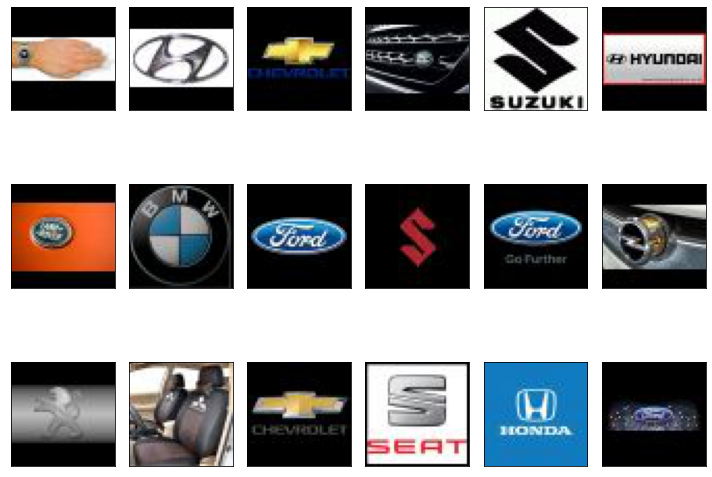

In [21]:
features, target = next(train_generator)

fig = plt.figure(figsize=(10,10))
for i in range(18):
    fig.add_subplot(3, 6, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Создание тестовой выборки.

In [17]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(
    image_path + 'test/',
    target_size=(50, 50),
    batch_size=128,
    class_mode='categorical',
    seed=42)

Found 2081 images belonging to 40 classes.


Использую нейросеть ResNet50 без двух последних слоёв, предобученную на датасете ImageNet. Алгоритм оптимизации SGD с разными значениями начального шага градиентного спуска, затуханием 1e-5 и импульсом 0.9

In [23]:
def load_model(lr):
    backbone = ResNet50(input_shape=(50, 50, 3), weights='imagenet', include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(40, activation='softmax'))

    sgd = SGD(lr=lr, decay=1e-5, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [27]:
def train_model(model, train_data, test_data, epochs,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model = model.fit(train_data,
              validation_data=test_data,epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, batch_size=128,
              verbose=1)
 
    return model

Создание моделей с различными значениями learning_rate

In [24]:
learning_rate = [0.01, 0.003, 0.001]

In [30]:
models_aug = []
for lr in learning_rate:
    model = load_model(lr)
    models_aug.append(model)


Обучение моделей на данных с аугментацией

In [31]:
trained_models_aug = []
for model in models_aug:
    trained_model = train_model(model, train_generator_aug, validation_generator, epochs=15)
    trained_models_aug.append(trained_model)

Epoch 1/15
110/110 [==============================] - 30s 276ms/step - loss: 2.5915 - accuracy: 0.3618 - val_loss: 4.0526 - val_accuracy: 0.0296
Epoch 2/15
110/110 [==============================] - 29s 260ms/step - loss: 1.3331 - accuracy: 0.6417 - val_loss: 4.0486 - val_accuracy: 0.0466
Epoch 3/15
110/110 [==============================] - 30s 269ms/step - loss: 0.9833 - accuracy: 0.7343 - val_loss: 3.7308 - val_accuracy: 0.0797
Epoch 4/15
110/110 [==============================] - 29s 264ms/step - loss: 0.7742 - accuracy: 0.7872 - val_loss: 3.0293 - val_accuracy: 0.2164
Epoch 5/15
110/110 [==============================] - 30s 269ms/step - loss: 0.6429 - accuracy: 0.8206 - val_loss: 2.0242 - val_accuracy: 0.4653
Epoch 6/15
110/110 [==============================] - 29s 259ms/step - loss: 0.5516 - accuracy: 0.8420 - val_loss: 1.5775 - val_accuracy: 0.5860
Epoch 7/15
110/110 [==============================] - 29s 266ms/step - loss: 0.4624 - accuracy: 0.8686 - val_loss: 1.2544 - val_ac

Обучение моделей на данных без аугментации

In [33]:
models = []
for lr in learning_rate:
    model = load_model(lr)
    models.append(model)

In [34]:
trained_models = []
for model in models:
    trained_model = train_model(model, train_generator, validation_generator, epochs=15)
    trained_models.append(trained_model)

Epoch 1/15
110/110 [==============================] - 15s 134ms/step - loss: 2.0130 - accuracy: 0.5109 - val_loss: 4.1739 - val_accuracy: 0.0286
Epoch 2/15
110/110 [==============================] - 15s 134ms/step - loss: 0.7486 - accuracy: 0.8021 - val_loss: 3.7709 - val_accuracy: 0.0702
Epoch 3/15
110/110 [==============================] - 14s 124ms/step - loss: 0.3487 - accuracy: 0.9045 - val_loss: 3.8995 - val_accuracy: 0.1078
Epoch 4/15
110/110 [==============================] - 14s 126ms/step - loss: 0.1572 - accuracy: 0.9584 - val_loss: 2.5227 - val_accuracy: 0.3869
Epoch 5/15
110/110 [==============================] - 13s 122ms/step - loss: 0.0741 - accuracy: 0.9809 - val_loss: 1.9854 - val_accuracy: 0.5471
Epoch 6/15
110/110 [==============================] - 15s 135ms/step - loss: 0.0476 - accuracy: 0.9882 - val_loss: 1.4447 - val_accuracy: 0.6777
Epoch 7/15
110/110 [==============================] - 13s 122ms/step - loss: 0.0342 - accuracy: 0.9915 - val_loss: 1.0266 - val_ac

Проверка моделей на тестовой выборке

In [32]:
print('Обучение с аугментацией:')
for i in range(len(models_aug)):
    print('Learning rate:', learning_rate[i])
    models_aug[i].evaluate(test_generator)

Обучение с аугментацией:
Learning rate: 0.01
17/17 [==============================] - 3s 200ms/step - loss: 0.9957 - accuracy: 0.7934
Learning rate: 0.003
17/17 [==============================] - 1s 70ms/step - loss: 0.8011 - accuracy: 0.8352
Learning rate: 0.001
17/17 [==============================] - 1s 71ms/step - loss: 0.8749 - accuracy: 0.7963


In [35]:
print('Обучение без аугментации:')
for i in range(len(models)):
    print('Learning rate:', learning_rate[i])
    models[i].evaluate(test_generator)

Обучение без аугментации:
Learning rate: 0.01
17/17 [==============================] - 2s 90ms/step - loss: 0.8116 - accuracy: 0.8630
Learning rate: 0.003
17/17 [==============================] - 1s 75ms/step - loss: 0.8501 - accuracy: 0.8309
Learning rate: 0.001
17/17 [==============================] - 1s 79ms/step - loss: 1.0551 - accuracy: 0.7818



Построение графиков изменения Accuracy в процессе обучения и валидации моделей

In [36]:
def plot_models(models, title_aug):
    for i in range(len(models)):
        plt.plot(models[i].history['accuracy'], label='accuracy train')
        plt.plot(models[i].history['val_accuracy'], label='accuracy valid')
        plt.title(f'Model accuracy(lr={learning_rate[i]}, {title_aug})')
        plt.ylabel('accuracy')
        plt.xlabel('эпоха')
        plt.legend(loc="upper left")
        plt.show()

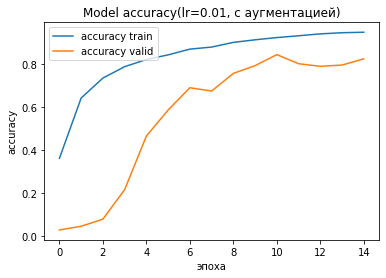

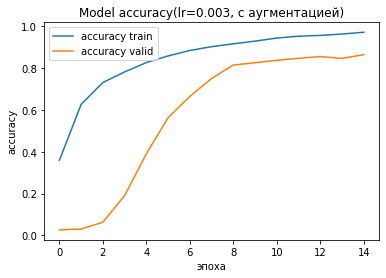

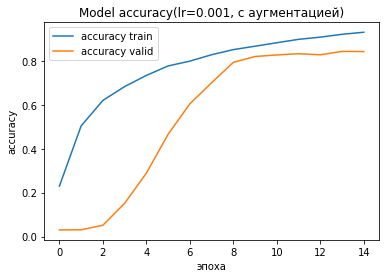

In [37]:
plot_models(trained_models_aug, 'с аугментацией')

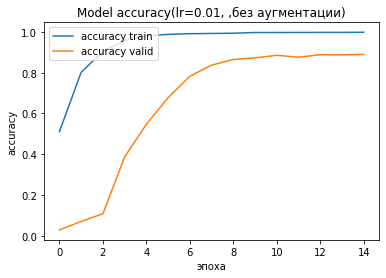

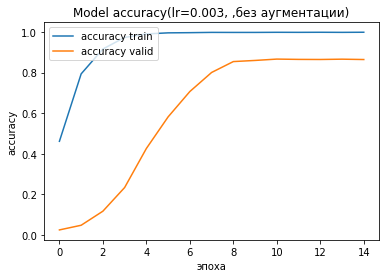

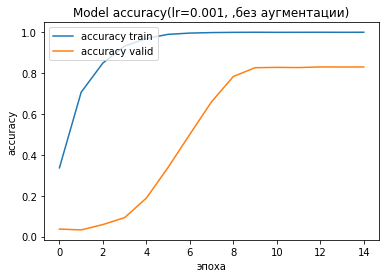

In [38]:
plot_models(trained_models, ',без аугментации')

#### Вывод:
- На тестовой выборке лучшее значение accuracy 0.86 получено моделью, обученной без аугментации и с начальным шагом градиентного спуска 0.01